In [40]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [41]:
df = pd.read_csv('C:\\Users\\DHAN RAJ\\Downloads\\btp_forecast_preprocessed_data\\kolkata\\daily\\imputed_daily_kolkata_data.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df

,Timestamp,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),...,Toluene (µg/m³),Eth-Benzene (µg/m³),MP-Xylene (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),TOT-RF (mm),SR (W/mt2),VWS (m/s)
0,2021-01-01,122.910000,237.360000,44.340000,54.730000,99.080000,39.600000,12.350000,1.260000,56.180000,...,18.400000,4.520000,20.600000,18.890000,57.500000,0.480000,226.470000,0.0,50.990000,0.050000
1,2021-01-02,202.910000,352.270000,61.300000,70.560000,131.880000,43.220000,13.530000,1.700000,46.580000,...,19.630000,5.710000,22.480000,18.550000,59.870000,0.330000,264.160000,0.0,49.790000,0.040000
2,2021-01-03,201.110000,346.930000,126.600000,69.790000,196.390000,51.450000,8.110000,2.160000,43.680000,...,31.630000,8.000000,36.370000,19.070000,65.900000,0.210000,193.850000,0.0,49.870000,0.040000
3,2021-01-04,140.190000,250.070000,65.660000,65.960000,131.800000,44.010000,10.030000,1.730000,41.240000,...,26.230000,8.080000,30.920000,20.510000,64.640000,0.250000,155.850000,0.0,51.500000,0.050000
4,2021-01-05,100.690000,195.650000,48.950000,53.360000,102.310000,41.400000,10.430000,1.310000,41.560000,...,25.750000,7.920000,29.060000,21.650000,64.370000,0.280000,197.010000,0.0,51.450000,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2023-12-27,102.056818,192.960606,38.160069,68.198264,66.286806,57.272014,9.852222,0.885035,24.048021,...,34.589965,3.950382,8.392951,21.525972,87.669340,0.426285,274.692604,0.0,95.821181,0.046875
1091,2023-12-28,100.370486,218.356250,58.416319,64.971528,80.855903,59.050382,11.010035,1.105486,26.166146,...,43.237812,5.081667,9.463750,21.222708,86.983889,0.672535,267.221146,0.0,98.272917,0.050694
1092,2023-12-29,94.957639,181.918750,45.421875,66.207986,71.082292,60.701597,12.285451,0.921493,30.569965,...,38.746319,3.882222,8.066528,21.666319,85.071562,0.622257,298.891597,0.0,101.918750,0.057917
1093,2023-12-30,94.909722,177.154167,21.308681,65.942361,51.599653,59.268125,20.464722,0.611042,33.371840,...,25.318819,3.728021,6.948403,22.252465,76.333646,0.859514,318.645521,0.0,105.551042,0.057083


In [42]:
val = pd.read_excel("C:/Users/DHAN RAJ/Downloads/Kolkata_daily_Jan.xlsx")
df.set_index('Timestamp', inplace=True)

In [43]:
training_data_len = math.ceil(len(df) * .8)
training_data_len
 
#Splitting the dataset
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(876, 1) (219, 1)


In [44]:
dataset_train = np.reshape(train_data['PM2.5 (µg/m³)'], (-1,1))
dataset_train.shape

(876, 1)

In [45]:
val

,From Date,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,...,O-Xylene,RH,WS,WD,SR,BP,VWS,AT,RF,TOT-RF
0,01-01-2024 00:00,102.58,191.37,16.56,54.26,41.69,47.53,16.27,0.72,37.42,...,2.14,89.46,0.75,303.40,111.83,1012.38,0.06,19.58,0.00,0.0
1,02-01-2024 00:00,97.01,166.67,11.01,56.17,38.25,48.82,12.40,0.59,34.69,...,2.21,77.42,0.78,312.54,107.22,1012.43,0.05,18.94,0.00,0.0
2,03-01-2024 00:00,93.04,155.73,32.80,58.83,57.12,44.85,10.04,0.90,38.34,...,2.66,82.06,0.68,283.70,118.01,1011.94,0.06,19.23,0.00,0.0
3,04-01-2024 00:00,105.41,179.82,65.60,83.56,96.33,60.10,12.13,1.29,31.97,...,4.02,84.47,0.45,265.04,105.73,1011.92,0.05,20.09,0.00,0.0
4,05-01-2024 00:00,119.15,216.05,82.03,92.42,114.14,74.07,15.65,1.69,33.96,...,4.77,76.53,0.33,258.87,112.14,1012.47,0.05,20.60,0.00,0.0
5,06-01-2024 00:00,112.77,194.71,45.72,85.59,81.46,69.76,16.47,1.22,31.06,...,3.93,75.54,0.50,288.39,108.57,1012.99,0.06,21.45,0.00,0.0
6,07-01-2024 00:00,125.58,220.08,15.39,63.96,45.83,61.95,19.91,0.89,37.72,...,2.18,82.71,0.59,308.93,106.60,1013.70,0.05,22.25,0.00,0.0
7,08-01-2024 00:00,127.41,213.73,10.10,57.84,38.38,60.44,19.23,0.78,37.62,...,1.96,89.16,0.73,310.25,110.78,1014.03,0.06,24.05,0.00,0.0
8,09-01-2024 00:00,109.73,182.55,23.08,60.63,50.25,57.29,12.97,0.89,38.60,...,2.74,86.84,0.64,293.32,115.39,1013.17,0.05,23.79,0.00,0.0
9,10-01-2024 00:00,111.51,203.43,46.29,86.07,82.15,68.99,12.53,1.29,38.10,...,2.41,77.89,0.37,273.40,112.23,1011.43,0.05,23.83,0.00,0.0


In [46]:
origin = '2021-01-01'
start = '2024-01-01'
end = '2024-01-31'
time_period = pd.date_range(start,end)
val['From Date'] = time_period
val.set_index('From Date', inplace=True)

In [47]:
val

,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,Benzene,...,O-Xylene,RH,WS,WD,SR,BP,VWS,AT,RF,TOT-RF
From Date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,102.58,191.37,16.56,54.26,41.69,47.53,16.27,0.72,37.42,12.11,...,2.14,89.46,0.75,303.40,111.83,1012.38,0.06,19.58,0.00,0.0
2024-01-02,97.01,166.67,11.01,56.17,38.25,48.82,12.40,0.59,34.69,20.14,...,2.21,77.42,0.78,312.54,107.22,1012.43,0.05,18.94,0.00,0.0
2024-01-03,93.04,155.73,32.80,58.83,57.12,44.85,10.04,0.90,38.34,25.69,...,2.66,82.06,0.68,283.70,118.01,1011.94,0.06,19.23,0.00,0.0
2024-01-04,105.41,179.82,65.60,83.56,96.33,60.10,12.13,1.29,31.97,33.04,...,4.02,84.47,0.45,265.04,105.73,1011.92,0.05,20.09,0.00,0.0
2024-01-05,119.15,216.05,82.03,92.42,114.14,74.07,15.65,1.69,33.96,46.25,...,4.77,76.53,0.33,258.87,112.14,1012.47,0.05,20.60,0.00,0.0
2024-01-06,112.77,194.71,45.72,85.59,81.46,69.76,16.47,1.22,31.06,35.99,...,3.93,75.54,0.50,288.39,108.57,1012.99,0.06,21.45,0.00,0.0
2024-01-07,125.58,220.08,15.39,63.96,45.83,61.95,19.91,0.89,37.72,15.05,...,2.18,82.71,0.59,308.93,106.60,1013.70,0.05,22.25,0.00,0.0
2024-01-08,127.41,213.73,10.10,57.84,38.38,60.44,19.23,0.78,37.62,19.89,...,1.96,89.16,0.73,310.25,110.78,1014.03,0.06,24.05,0.00,0.0
2024-01-09,109.73,182.55,23.08,60.63,50.25,57.29,12.97,0.89,38.60,17.63,...,2.74,86.84,0.64,293.32,115.39,1013.17,0.05,23.79,0.00,0.0


In [48]:
dataset_val = np.reshape(val['PM2.5'], (-1,1))
dataset_val.shape

(31, 1)

In [49]:
dataset_test = np.reshape(test_data['PM2.5 (µg/m³)'], (-1,1))
dataset_test.shape

(219, 1)

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test

[[0.59522364]
 [1.        ]
 [0.99089253]
 [0.68265533]
 [0.482797  ]]
[0.18919597] [0.17612114] [0.24518947] [0.2452965] [0.21719797]


In [51]:
# Create sequences and labels for training data
sequence_length = 4 # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
	X_train.append(scaled_train[i:i+sequence_length])
	y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([872, 4, 1]), torch.Size([872, 4, 1]))

In [52]:
# Create sequences and labels for testing data
sequence_length = 1 # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
	X_test.append(scaled_test[i:i+sequence_length])
	y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([218, 1, 1]), torch.Size([218, 1, 1]))

In [53]:
class LSTMModel(nn.Module):
	# input_size : number of features in input at each time step
	# hidden_size : Number of LSTM units 
	# num_layers : number of LSTM layers 
	def __init__(self, input_size, hidden_size, num_layers): 
		super(LSTMModel, self).__init__() #initializes the parent class nn.Module
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
		self.linear = nn.Linear(hidden_size, 1)

	def forward(self, x): # defines forward pass of the neural network
		out, _ = self.lstm(x)
		out = self.linear(out)
		return out

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [55]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [56]:
batch_size = 16
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [57]:
num_epochs = 150
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/150] - Training Loss: 0.0080, Test Loss: 0.0076
Epoch [20/150] - Training Loss: 0.0067, Test Loss: 0.0057
Epoch [30/150] - Training Loss: 0.0065, Test Loss: 0.0055
Epoch [40/150] - Training Loss: 0.0064, Test Loss: 0.0054
Epoch [50/150] - Training Loss: 0.0063, Test Loss: 0.0054
Epoch [60/150] - Training Loss: 0.0062, Test Loss: 0.0054
Epoch [70/150] - Training Loss: 0.0062, Test Loss: 0.0054
Epoch [80/150] - Training Loss: 0.0061, Test Loss: 0.0054
Epoch [90/150] - Training Loss: 0.0061, Test Loss: 0.0054
Epoch [100/150] - Training Loss: 0.0060, Test Loss: 0.0054
Epoch [110/150] - Training Loss: 0.0060, Test Loss: 0.0054
Epoch [120/150] - Training Loss: 0.0060, Test Loss: 0.0054
Epoch [130/150] - Training Loss: 0.0060, Test Loss: 0.0054
Epoch [140/150] - Training Loss: 0.0060, Test Loss: 0.0054
Epoch [150/150] - Training Loss: 0.0059, Test Loss: 0.0054


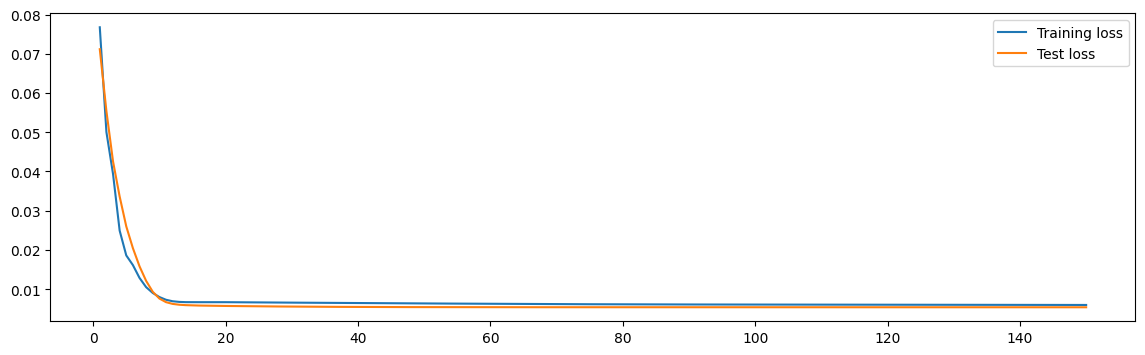

In [58]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [59]:
# Define the number of future time steps to forecast
num_forecast_steps = 31

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
	for _ in range(num_forecast_steps*2):
		# Prepare the historical_data tensor
		historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
		# Use the model to predict the next value
		predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

		# Append the predicted value to the forecasted_values list
		forecasted_values.append(predicted_value[0])

		# Update the historical_data sequence by removing the oldest value and adding the predicted value
		historical_data = np.roll(historical_data, shift=-1)
		historical_data = predicted_value

		
# Generate futute dates
last_date = test_data.index[-1]

# Generate the next 24 hours
future_dates = time_period
# Concatenate the original index with the future dates
combined_index = test_data.index.append(future_dates)

In [64]:
test_data

,PM2.5 (µg/m³)
Timestamp,
2023-05-27,40.639583
2023-05-28,38.382292
2023-05-29,50.306522
2023-05-30,50.325000
2023-05-31,45.473958
...,...
2023-12-27,102.056818
2023-12-28,100.370486
2023-12-29,94.957639


In [65]:
combined_index[-31:]

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-20',
               '2024-01-21', '2024-01-22', '2024-01-23', '2024-01-24',
               '2024-01-25', '2024-01-26', '2024-01-27', '2024-01-28',
               '2024-01-29', '2024-01-30', '2024-01-31'],
              dtype='datetime64[ns]', freq=None)

In [67]:
test_data_[-100:]

2023-10-24     13.018750
2023-10-25     33.681250
2023-10-26     55.551042
2023-10-27     74.500000
2023-10-28     96.267014
                 ...    
2024-01-27     98.850000
2024-01-28    115.180000
2024-01-29     98.280000
2024-01-30     69.200000
2024-01-31     58.320000
Length: 100, dtype: float64

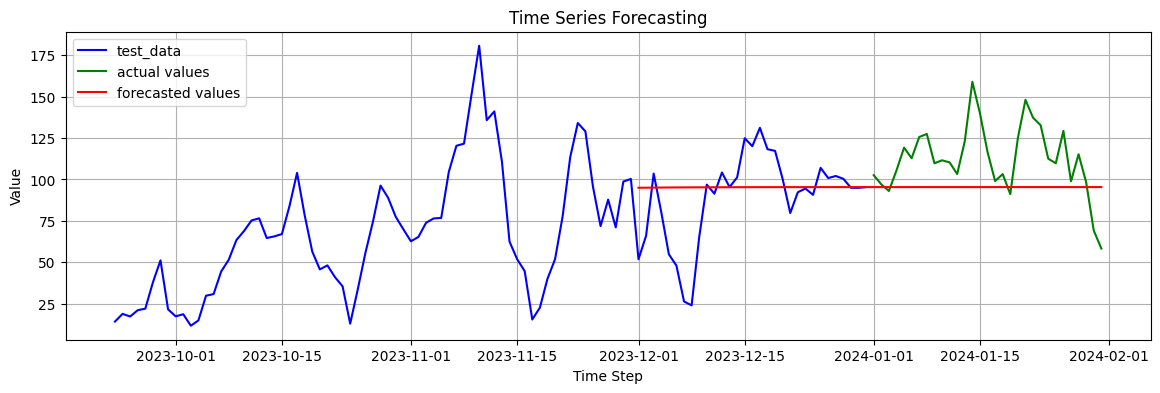

In [72]:
#set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 

#Test data
plt.plot(test_data['PM2.5 (µg/m³)'].index[-100:], test_data['PM2.5 (µg/m³)'][-100:], label = "test_data", color = "b") 
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0).reshape(-1,1)).flatten() 

#the historical data used as input for forecasting
plt.plot(combined_index[-31:], val['PM2.5'], label='actual values', color='green') 

#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# plotting the forecasted values
plt.plot(combined_index[-62:], forecasted_cases, label='forecasted values', color='red') 

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)


Text(0.5, 1.0, 'Time Series Forecasting')

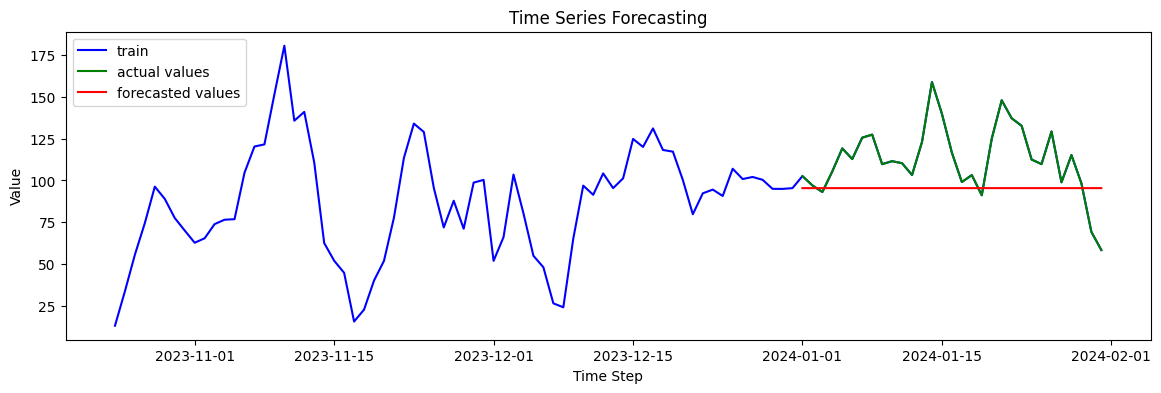

In [73]:
#set the size of the plot 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 4] 
val.index = combined_index[-31:]
test_data_ = pd.concat([test_data['PM2.5 (µg/m³)'],val['PM2.5']])
test_data_.columns = 'PM2.5 (µg/m³)'
#Test data
plt.plot(test_data_.index[-100:], test_data_[-100:], label = "train", color = "b") 
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0).reshape(-1,1)).flatten() 

#the historical data used as input for forecasting
plt.plot(combined_index[-31:], val['PM2.5'], label='actual values', color='green') 

#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# plotting the forecasted values
plt.plot(combined_index[-31:], forecasted_cases[-31:], label='forecasted values', color='red') 

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')

In [70]:
mae = (forecasted_cases[-31:] - val['PM2.5']).abs().mean()

In [71]:
mae

21.49686575612714